In [1]:
import pandas as pd
import numpy as np

import category_encoders as ce

from pycaret.classification import *

import warnings
warnings.simplefilter('ignore')


# Obtencion de datos

In [13]:
# carga de datos
raw_data = pd.read_csv(r'C:\Users\ragod\OneDrive\Escritorio\Trabajo\Proyectos_TB\clasificacion\data\train.csv')
test = pd.read_csv(r'C:\Users\ragod\OneDrive\Escritorio\Trabajo\Proyectos_TB\clasificacion\data\test.csv')

# Analisis de datos

In [14]:
X_raw=raw_data.drop('Churn', axis=1)

y=raw_data.Churn

In [15]:
X_numeric=X_raw._get_numeric_data().drop('id', axis=1)

X_numeric.head()

,SeniorCitizen,tenure,MonthlyCharges
0,0,1,25.30
1,0,7,75.15
2,0,4,20.05
3,0,29,76.00
4,0,3,75.10


In [16]:
# valores unicos
object_cols=[]
object_cols =[c for c in raw_data.select_dtypes(include=object)]  # para cada columna object...

# tabulacion de valores en numeros
object_cols2 =[
 'gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

dictionary = {}
for c in object_cols2:
    dictionary.update({c:raw_data[c].unique() })
    
pd.DataFrame([dictionary])

#Cambio de valor de las variables categoricas:
# las dependientes de Servicos de internet solo valores No y No Internet Service = 0, Si =1
#Gender: Male:0 Female:1
#Partner: No:0 Yes:1
#Dependents: NO:0 yes:1
#PhoneService: No:0 Yes:1
#paperlessBilling: No:0 Yes:1
# Se aplica get_dummy a MultipleLines,Internetservice, Contract y PaymentMethod 
codificacion = [{'col':'gender','mapping':{'Male':0, 'Female':1}},
                {'col' :'Partner', 'mapping':{'No':0, 'Yes':1}},
                {'col' :'Dependents', 'mapping':{'No':0, 'Yes':1}},
                {'col':'PhoneService','mapping':{'No':0, 'Yes':1}},
                {'col':'PaperlessBilling','mapping':{'No':0, 'Yes':1}},
                {'col':'OnlineSecurity','mapping':{'No':0, 'No internet service':0, 'Yes':1}},
                {'col':'OnlineBackup','mapping':{'No':0, 'No internet service':0, 'Yes':1}},
                {'col':'TechSupport','mapping':{'No':0, 'No internet service':0, 'Yes':1}},
                {'col':'StreamingTV','mapping':{'No':0, 'No internet service':0, 'Yes':1}},
                {'col':'DeviceProtection','mapping':{'No':0, 'No internet service':0, 'Yes':1}},
                {'col':'StreamingMovies','mapping':{'No':0, 'No internet service':0, 'Yes':1}} ]
# Aplicamos la transformación  a las variables catgeoricas
encoder = ce.OrdinalEncoder(cols = ['gender',
                                    'Partner',
                                    'Dependents',
                                    'PhoneService',
                                    'PaperlessBilling',
                                    'OnlineSecurity',
                                     'OnlineBackup',
                                     'DeviceProtection',
                                     'TechSupport',
                                     'StreamingTV',
                                     'StreamingMovies'], mapping= codificacion)

df_encoded =encoder.fit_transform(raw_data)

# Aplicamos la obtencion de dummies


# Definimos qué columnas serán dummificadas y cómo deben ser interpretadas
# Cada clave del diccionario equivale a un nombre de columna
# `prefix` es el prefijo que se añadirá a cada columna dummy
# `sep` especifica el caracter separador de los elementos de la celda
dummy_columns = {
    'Contract': {
        'prefix': 'Cont_',
        'sep': ';'
    },
   'MultipleLines':{
        'prefix': 'Mlines_',
        'sep': ';'
    },
    'InternetService':{
        'prefix': 'IS_',
        'sep': ';'
    },     
    'PaymentMethod':{
        'prefix': 'PayM_',
        'sep': ';'
    } 
    # Aquí podemos añadir todas las columnas que queramos
}

for column_name, dummy_data in dummy_columns.items():
	# Recogemos un DataFrame con una columna dummy por cada valor
    dummies = df_encoded[column_name].str.get_dummies(sep=dummy_data['sep'])

    # Añadimos `prefix` a cada columna
    dummies.columns = map(lambda col: f'{dummy_data["prefix"]}_{col}', dummies.columns)
    
    # Añadimos las columnas dummy al df original
    df_encoded2 = pd.concat([df_encoded, dummies], axis=1)

# [Opcional] Eliminamos las columnas originales de df
df_encoded2 = df_encoded2.drop(columns=dummy_columns.keys())

# Ahora df.head() mostrará las columnas dummy
df_encoded2.head()

df_encoded3 = df_encoded2.drop(['customerID','TotalCharges','id'], axis = 1)


In [19]:
df_encoded3.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,Churn,PayM__Bank transfer (automatic),PayM__Credit card (automatic),PayM__Electronic check,PayM__Mailed check
0,0,0,0,1,1,0,0,0,0,0,0,0,1,25.30,1,0,0,1,0
1,1,0,0,0,7,1,0,0,1,0,0,0,1,75.15,0,0,0,1,0
2,1,0,0,1,4,1,0,0,0,0,0,0,1,20.05,0,1,0,0,0
3,1,0,0,0,29,1,0,0,0,0,0,0,1,76.00,0,0,1,0,0
4,1,0,0,0,3,1,0,0,0,0,0,0,1,75.10,1,0,1,0,0


In [20]:
exp_clf101 = setup(data = df_encoded3, target = 'Churn', session_id=123, fix_imbalance = True)

,Description,Value
0,session_id,123
1,Target,Churn
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(5282, 19)"
5,Missing Values,False
6,Numeric Features,13
7,Categorical Features,5
8,Ordinal Features,False
9,High Cardinality Features,False


In [21]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7804,0.8194,0.5800,0.5876,0.5833,0.4343,0.4346,1.6030
gbc,Gradient Boosting Classifier,0.7801,0.8259,0.6055,0.5825,0.5929,0.4426,0.4433,0.1320
lightgbm,Light Gradient Boosting Machine,0.7779,0.8094,0.5616,0.5859,0.5728,0.4230,0.4237,0.1920
ada,Ada Boost Classifier,0.7752,0.8238,0.6381,0.5682,0.6001,0.4447,0.4469,0.0630
xgboost,Extreme Gradient Boosting,0.7701,0.8007,0.5454,0.5706,0.5571,0.4021,0.4027,0.1740
rf,Random Forest Classifier,0.7690,0.7965,0.5056,0.5757,0.5373,0.3845,0.3866,0.1240
lr,Logistic Regression,0.7617,0.8184,0.6880,0.5397,0.6040,0.4372,0.4447,0.4530
lda,Linear Discriminant Analysis,0.7549,0.8190,0.7074,0.5283,0.6043,0.4321,0.4425,0.0110
ridge,Ridge Classifier,0.7547,0.0000,0.7074,0.5279,0.6040,0.4317,0.4421,0.0090
et,Extra Trees Classifier,0.7420,0.7628,0.4639,0.5152,0.4873,0.3159,0.3171,0.1270


In [22]:
Logreg=create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7649,0.7906,0.6224,0.5495,0.5837,0.4208,0.4224
1,0.7730,0.8315,0.7449,0.5530,0.6348,0.4752,0.4863
2,0.7973,0.8702,0.7959,0.5865,0.6753,0.5328,0.5460
3,0.7703,0.8468,0.7551,0.5481,0.6352,0.4736,0.4866
4,0.7514,0.7800,0.5816,0.5278,0.5534,0.3817,0.3825
5,0.7676,0.8119,0.7245,0.5462,0.6228,0.4596,0.4692
6,0.7676,0.8367,0.7273,0.5496,0.6261,0.4622,0.4717
7,0.7100,0.7929,0.6327,0.4662,0.5368,0.3327,0.3410
8,0.7669,0.8144,0.6939,0.5484,0.6126,0.4492,0.4556
9,0.7480,0.8090,0.6020,0.5221,0.5592,0.3840,0.3859


In [23]:
tuned_Logreg = tune_model(Logreg)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7676,0.7933,0.6224,0.5545,0.5865,0.4256,0.4270
1,0.7784,0.8368,0.7653,0.5597,0.6466,0.4907,0.5035
2,0.8000,0.8704,0.7959,0.5909,0.6783,0.5377,0.5503
3,0.7703,0.8522,0.7653,0.5474,0.6383,0.4767,0.4911
4,0.7432,0.7829,0.5612,0.5140,0.5366,0.3595,0.3602
5,0.7649,0.8127,0.7347,0.5414,0.6234,0.4581,0.4694
6,0.7730,0.8393,0.7576,0.5556,0.6410,0.4807,0.4931
7,0.7073,0.7992,0.6327,0.4627,0.5345,0.3285,0.3370
8,0.7642,0.8149,0.6735,0.5455,0.6027,0.4377,0.4426
9,0.7588,0.8115,0.6327,0.5391,0.5822,0.4141,0.4168


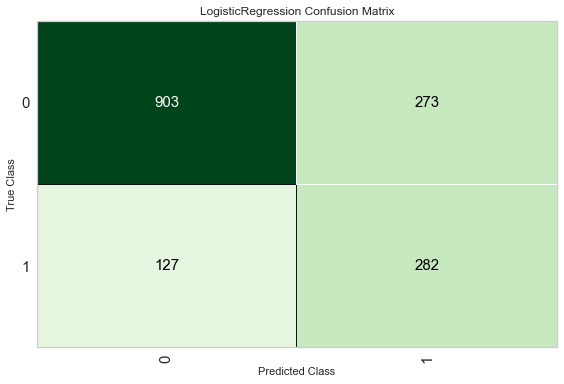

In [24]:
plot_model(tuned_Logreg, plot = 'confusion_matrix')

In [25]:
predict_model(tuned_Logreg);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7476,0.8124,0.6895,0.5081,0.5851,0.4097,0.4195


In [26]:
final_Logreg = finalize_model(tuned_Logreg)

# Aplicacion a la prueba

In [27]:
df_encoded =encoder.fit_transform(test)

# Aplicamos la obtencion de dummies


# Definimos qué columnas serán dummificadas y cómo deben ser interpretadas
# Cada clave del diccionario equivale a un nombre de columna
# `prefix` es el prefijo que se añadirá a cada columna dummy
# `sep` especifica el caracter separador de los elementos de la celda
dummy_columns = {
    'Contract': {
        'prefix': 'Cont_',
        'sep': ';'
    },
   'MultipleLines':{
        'prefix': 'Mlines_',
        'sep': ';'
    },
    'InternetService':{
        'prefix': 'IS_',
        'sep': ';'
    },     
    'PaymentMethod':{
        'prefix': 'PayM_',
        'sep': ';'
    } 
    # Aquí podemos añadir todas las columnas que queramos
}

for column_name, dummy_data in dummy_columns.items():
	# Recogemos un DataFrame con una columna dummy por cada valor
    dummies = df_encoded[column_name].str.get_dummies(sep=dummy_data['sep'])

    # Añadimos `prefix` a cada columna
    dummies.columns = map(lambda col: f'{dummy_data["prefix"]}_{col}', dummies.columns)
    
    # Añadimos las columnas dummy al df original
    df_encoded2 = pd.concat([df_encoded, dummies], axis=1)

# [Opcional] Eliminamos las columnas originales de df
df_encoded2 = df_encoded2.drop(columns=dummy_columns.keys())

# Ahora df.head() mostrará las columnas dummy
df_encoded2.head()

df_encoded3 = df_encoded2.drop(['customerID','TotalCharges','id'], axis = 1)


In [28]:
df_encoded3

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,PayM__Bank transfer (automatic),PayM__Credit card (automatic),PayM__Electronic check,PayM__Mailed check
0,1,0,1,0,1,0,0,0,0,0,0,0,1,24.80,0,0,1,0
1,0,0,0,0,41,1,0,0,0,0,0,0,1,25.25,1,0,0,0
2,1,0,1,1,52,1,0,0,0,0,0,0,0,19.35,0,0,0,1
3,1,0,0,0,1,1,0,0,1,0,0,0,0,76.35,0,0,1,0
4,0,0,0,0,67,1,0,0,0,1,0,0,0,50.55,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,1,0,0,0,3,1,0,0,0,0,0,0,1,75.80,0,0,1,0
1757,1,0,1,0,8,1,0,0,0,1,0,1,1,90.25,0,0,1,0
1758,0,0,0,0,29,1,0,1,1,0,0,1,0,70.90,0,1,0,0
1759,1,0,0,0,2,0,0,0,0,0,0,1,1,34.70,0,0,1,0


In [29]:
y_pred = predict_model(final_Logreg , data=df_encoded3)



In [30]:
y_pred= pd.DataFrame(y_pred)
y_pred2=pd.DataFrame(y_pred['Label'])

In [31]:

y_pred2.columns=['Churn']


y_pred2.insert(1,'id',test['id'], True)

In [32]:
y_pred2.to_csv(r'C:\Users\ragod\OneDrive\Escritorio\Trabajo\Proyectos_TB\clasificacion\ramon_LogReg_SMOTE_pycaret.csv', index= False, sep=',')

In [33]:
Linear_Discriminant=create_model('lda')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7595,0.7922,0.6735,0.5366,0.5973,0.4289,0.4345
1,0.7676,0.8295,0.7551,0.5441,0.6325,0.4690,0.4825
2,0.8000,0.8729,0.8163,0.5882,0.6838,0.5431,0.5587
3,0.7568,0.8463,0.7653,0.5282,0.6250,0.4538,0.4709
4,0.7297,0.7817,0.5918,0.4915,0.5370,0.3485,0.3515
5,0.7595,0.8161,0.7245,0.5338,0.6147,0.4456,0.4566
6,0.7622,0.8351,0.7576,0.5396,0.6303,0.4622,0.4766
7,0.7073,0.7929,0.6633,0.4643,0.5462,0.3400,0.3518
8,0.7561,0.8157,0.6939,0.5312,0.6018,0.4304,0.4384
9,0.7507,0.8078,0.6327,0.5254,0.5741,0.4000,0.4034


In [34]:
tuned_Linear_Discriminant = tune_model(Linear_Discriminant)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7568,0.7936,0.6735,0.5323,0.5946,0.4242,0.4302
1,0.7676,0.8302,0.7551,0.5441,0.6325,0.4690,0.4825
2,0.7973,0.8726,0.8163,0.5839,0.6809,0.5383,0.5545
3,0.7568,0.8481,0.7653,0.5282,0.6250,0.4538,0.4709
4,0.7270,0.7830,0.5918,0.4874,0.5346,0.3440,0.3472
5,0.7595,0.8163,0.7347,0.5333,0.6180,0.4489,0.4611
6,0.7595,0.8354,0.7475,0.5362,0.6245,0.4545,0.4681
7,0.7073,0.7928,0.6633,0.4643,0.5462,0.3400,0.3518
8,0.7588,0.8155,0.7041,0.5349,0.6079,0.4384,0.4470
9,0.7534,0.8083,0.6327,0.5299,0.5767,0.4047,0.4078


In [35]:
predict_model(tuned_Linear_Discriminant);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.7382,0.8113,0.7017,0.4948,0.5804,0.3983,0.4111


In [36]:
final_LinearDisc= finalize_model(tuned_Linear_Discriminant)



In [37]:
y_pred = predict_model(final_LinearDisc , data=df_encoded3)



In [38]:
y_pred= pd.DataFrame(y_pred)
y_pred2=pd.DataFrame(y_pred['Label'])

y_pred2.columns=['Churn']
y_pred2.insert(1,'id',test['id'], True)
y_pred2.to_csv(r'C:\Users\ragod\OneDrive\Escritorio\Trabajo\Proyectos_TB\clasificacion\ramon_LinDesc_SMOTE_pycaret.csv', index= False, sep=',')